In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=1 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 31708 
    Total predicted counts          : 31616.73
    Total off counts                : 101765.00

    Total background counts         : 20353.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 2000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 5.95 s, sys: 36.6 ms, total: 5.99 s
Wall time: 5.99 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 31602 
    Total predicted counts          : 31630.33
    Total off counts                : 101833.00

    Total background counts         : 20366.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 31506 
    Total predicted counts          : 31662.13
    Total off counts                : 101992.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_28 

    Total counts                    : 31454 
    Total predicted counts          : 31481.33
    Total off counts                : 101088.00

    Total background counts         : 20217.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_29 

    Total counts                    : 31621 
    Total predicted counts          : 31595.53
    Total off counts                : 101659.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_63 

    Total counts                    : 31463 
    Total predicted counts          : 31557.93
    Total off counts                : 101471.00

    Total background counts         : 20294.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_64 

    Total counts                    : 31445 
    Total predicted counts          : 31522.53
    Total off counts                : 101294.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_99 

    Total counts                    : 31462 
    Total predicted counts          : 31574.93
    Total off counts                : 101556.00

    Total background counts         : 20311.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_100 

    Total counts                    : 31465 
    Total predicted counts          : 31498.53
    Total off counts                : 101174.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_135 

    Total counts                    : 31710 
    Total predicted counts          : 31668.53
    Total off counts                : 102024.00

    Total background counts         : 20404.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_136 

    Total counts                    : 31190 
    Total predicted counts          : 31562.13
    Total off counts                : 101492.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_169 

    Total counts                    : 31588 
    Total predicted counts          : 31523.53
    Total off counts                : 101299.00

    Total background counts         : 20259.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_170 

    Total counts                    : 31489 
    Total predicted counts          : 31639.33
    Total off counts                : 101878.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_203 

    Total counts                    : 31744 
    Total predicted counts          : 31505.93
    Total off counts                : 101211.00

    Total background counts         : 20242.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_204 

    Total counts                    : 31809 
    Total predicted counts          : 31536.73
    Total off counts                : 101365.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_235 

    Total counts                    : 31481 
    Total predicted counts          : 31459.13
    Total off counts                : 100977.00

    Total background counts         : 20195.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_236 

    Total counts                    : 31242 
    Total predicted counts          : 31586.13
    Total off counts                : 101612.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_271 

    Total counts                    : 31639 
    Total predicted counts          : 31587.73
    Total off counts                : 101620.00

    Total background counts         : 20324.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_272 

    Total counts                    : 31603 
    Total predicted counts          : 31630.93
    Total off counts                : 101836.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_305 

    Total counts                    : 31498 
    Total predicted counts          : 31619.33
    Total off counts                : 101778.00

    Total background counts         : 20355.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_306 

    Total counts                    : 31665 
    Total predicted counts          : 31499.93
    Total off counts                : 101181.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_339 

    Total counts                    : 31457 
    Total predicted counts          : 31610.73
    Total off counts                : 101735.00

    Total background counts         : 20347.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_340 

    Total counts                    : 31451 
    Total predicted counts          : 31600.73
    Total off counts                : 101685.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_373 

    Total counts                    : 31601 
    Total predicted counts          : 31690.53
    Total off counts                : 102134.00

    Total background counts         : 20426.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_374 

    Total counts                    : 31759 
    Total predicted counts          : 31606.53
    Total off counts                : 101714.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_409 

    Total counts                    : 31554 
    Total predicted counts          : 31519.73
    Total off counts                : 101280.00

    Total background counts         : 20256.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_410 

    Total counts                    : 31631 
    Total predicted counts          : 31467.93
    Total off counts                : 101021.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_445 

    Total counts                    : 31717 
    Total predicted counts          : 31498.33
    Total off counts                : 101173.00

    Total background counts         : 20234.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_446 

    Total counts                    : 31644 
    Total predicted counts          : 31617.73
    Total off counts                : 101770.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_479 

    Total counts                    : 31798 
    Total predicted counts          : 31584.73
    Total off counts                : 101605.00

    Total background counts         : 20321.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_480 

    Total counts                    : 31431 
    Total predicted counts          : 31530.13
    Total off counts                : 101332.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_515 

    Total counts                    : 31628 
    Total predicted counts          : 31636.33
    Total off counts                : 101863.00

    Total background counts         : 20372.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_516 

    Total counts                    : 31672 
    Total predicted counts          : 31599.13
    Total off counts                : 101677.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_552 

    Total counts                    : 31499 
    Total predicted counts          : 31620.53
    Total off counts                : 101784.00

    Total background counts         : 20356.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_553 

    Total counts                    : 31897 
    Total predicted counts          : 31618.13
    Total off counts                : 101772.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_588 

    Total counts                    : 31550 
    Total predicted counts          : 31566.13
    Total off counts                : 101512.00

    Total background counts         : 20302.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_589 

    Total counts                    : 31712 
    Total predicted counts          : 31512.73
    Total off counts                : 101245.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_624 

    Total counts                    : 31345 
    Total predicted counts          : 31525.53
    Total off counts                : 101309.00

    Total background counts         : 20261.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_625 

    Total counts                    : 31108 
    Total predicted counts          : 31586.33
    Total off counts                : 101613.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_661 

    Total counts                    : 31486 
    Total predicted counts          : 31622.33
    Total off counts                : 101793.00

    Total background counts         : 20358.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_662 

    Total counts                    : 31432 
    Total predicted counts          : 31553.33
    Total off counts                : 101448.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_696 

    Total counts                    : 31447 
    Total predicted counts          : 31591.73
    Total off counts                : 101640.00

    Total background counts         : 20328.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_697 

    Total counts                    : 31373 
    Total predicted counts          : 31554.53
    Total off counts                : 101454.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_730 

    Total counts                    : 31506 
    Total predicted counts          : 31646.93
    Total off counts                : 101916.00

    Total background counts         : 20383.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_731 

    Total counts                    : 31618 
    Total predicted counts          : 31536.53
    Total off counts                : 101364.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_767 

    Total counts                    : 31238 
    Total predicted counts          : 31565.73
    Total off counts                : 101510.00

    Total background counts         : 20302.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_768 

    Total counts                    : 31402 
    Total predicted counts          : 31515.53
    Total off counts                : 101259.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_794 

    Total counts                    : 31515 
    Total predicted counts          : 31562.93
    Total off counts                : 101496.00

    Total background counts         : 20299.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_795 

    Total counts                    : 31606 
    Total predicted counts          : 31561.93
    Total off counts                : 101491.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_830 

    Total counts                    : 31541 
    Total predicted counts          : 31671.13
    Total off counts                : 102037.00

    Total background counts         : 20407.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_831 

    Total counts                    : 31470 
    Total predicted counts          : 31553.33
    Total off counts                : 101448.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_865 

    Total counts                    : 31576 
    Total predicted counts          : 31677.73
    Total off counts                : 102070.00

    Total background counts         : 20414.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_866 

    Total counts                    : 31720 
    Total predicted counts          : 31791.33
    Total off counts                : 102638.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_902 

    Total counts                    : 31595 
    Total predicted counts          : 31490.13
    Total off counts                : 101132.00

    Total background counts         : 20226.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_903 

    Total counts                    : 31475 
    Total predicted counts          : 31582.53
    Total off counts                : 101594.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_937 

    Total counts                    : 31796 
    Total predicted counts          : 31572.13
    Total off counts                : 101542.00

    Total background counts         : 20308.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_938 

    Total counts                    : 31570 
    Total predicted counts          : 31534.93
    Total off counts                : 101356.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_973 

    Total counts                    : 31616 
    Total predicted counts          : 31504.93
    Total off counts                : 101206.00

    Total background counts         : 20241.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_974 

    Total counts                    : 31333 
    Total predicted counts          : 31596.33
    Total off counts                : 101663.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_1009 

    Total counts                    : 31506 
    Total predicted counts          : 31677.93
    Total off counts                : 102071.00

    Total background counts         : 20414.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1010 

    Total counts                    : 31297 
    Total predicted counts          : 31532.13
    Total off counts                : 101342.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1044 

    Total counts                    : 31501 
    Total predicted counts          : 31559.73
    Total off counts                : 101480.00

    Total background counts         : 20296.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1045 

    Total counts                    : 31698 
    Total predicted counts          : 31576.13
    Total off counts                : 101562.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1079 

    Total counts                    : 31309 
    Total predicted counts          : 31559.13
    Total off counts                : 101477.00

    Total background counts         : 20295.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1080 

    Total counts                    : 31750 
    Total predicted counts          : 31741.53
    Total off counts                : 102389.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1115 

    Total counts                    : 31759 
    Total predicted counts          : 31583.13
    Total off counts                : 101597.00

    Total background counts         : 20319.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1116 

    Total counts                    : 31711 
    Total predicted counts          : 31540.93
    Total off counts                : 101386.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1151 

    Total counts                    : 31626 
    Total predicted counts          : 31556.73
    Total off counts                : 101465.00

    Total background counts         : 20293.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1152 

    Total counts                    : 31640 
    Total predicted counts          : 31664.53
    Total off counts                : 102004.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1184 

    Total counts                    : 31700 
    Total predicted counts          : 31615.13
    Total off counts                : 101757.00

    Total background counts         : 20351.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1185 

    Total counts                    : 31592 
    Total predicted counts          : 31596.13
    Total off counts                : 101662.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1218 

    Total counts                    : 31678 
    Total predicted counts          : 31596.93
    Total off counts                : 101666.00

    Total background counts         : 20333.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1219 

    Total counts                    : 31565 
    Total predicted counts          : 31577.13
    Total off counts                : 101567.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1252 

    Total counts                    : 31500 
    Total predicted counts          : 31523.33
    Total off counts                : 101298.00

    Total background counts         : 20259.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1253 

    Total counts                    : 31528 
    Total predicted counts          : 31595.93
    Total off counts                : 101661.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1288 

    Total counts                    : 31381 
    Total predicted counts          : 31692.33
    Total off counts                : 102143.00

    Total background counts         : 20428.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1289 

    Total counts                    : 31542 
    Total predicted counts          : 31678.33
    Total off counts                : 102073.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1320 

    Total counts                    : 31681 
    Total predicted counts          : 31547.53
    Total off counts                : 101419.00

    Total background counts         : 20283.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1321 

    Total counts                    : 31723 
    Total predicted counts          : 31577.53
    Total off counts                : 101569.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1356 

    Total counts                    : 31407 
    Total predicted counts          : 31669.13
    Total off counts                : 102027.00

    Total background counts         : 20405.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1357 

    Total counts                    : 31879 
    Total predicted counts          : 31479.33
    Total off counts                : 101078.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1391 

    Total counts                    : 31504 
    Total predicted counts          : 31656.53
    Total off counts                : 101964.00

    Total background counts         : 20392.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1392 

    Total counts                    : 31420 
    Total predicted counts          : 31592.73
    Total off counts                : 101645.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1427 

    Total counts                    : 31647 
    Total predicted counts          : 31548.93
    Total off counts                : 101426.00

    Total background counts         : 20285.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1428 

    Total counts                    : 31625 
    Total predicted counts          : 31648.93
    Total off counts                : 101926.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1461 

    Total counts                    : 31876 
    Total predicted counts          : 31494.13
    Total off counts                : 101152.00

    Total background counts         : 20230.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1462 

    Total counts                    : 31681 
    Total predicted counts          : 31561.93
    Total off counts                : 101491.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1498 

    Total counts                    : 31801 
    Total predicted counts          : 31565.93
    Total off counts                : 101511.00

    Total background counts         : 20302.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1499 

    Total counts                    : 31519 
    Total predicted counts          : 31581.13
    Total off counts                : 101587.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1533 

    Total counts                    : 31456 
    Total predicted counts          : 31535.93
    Total off counts                : 101361.00

    Total background counts         : 20272.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1534 

    Total counts                    : 31764 
    Total predicted counts          : 31536.73
    Total off counts                : 101365.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1569 

    Total counts                    : 31490 
    Total predicted counts          : 31527.53
    Total off counts                : 101319.00

    Total background counts         : 20263.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1570 

    Total counts                    : 31675 
    Total predicted counts          : 31581.73
    Total off counts                : 101590.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1605 

    Total counts                    : 31983 
    Total predicted counts          : 31659.33
    Total off counts                : 101978.00

    Total background counts         : 20395.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1606 

    Total counts                    : 31687 
    Total predicted counts          : 31583.93
    Total off counts                : 101601.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1639 

    Total counts                    : 31757 
    Total predicted counts          : 31539.33
    Total off counts                : 101378.00

    Total background counts         : 20275.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1640 

    Total counts                    : 31917 
    Total predicted counts          : 31481.13
    Total off counts                : 101087.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1675 

    Total counts                    : 31527 
    Total predicted counts          : 31581.53
    Total off counts                : 101589.00

    Total background counts         : 20317.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1676 

    Total counts                    : 31993 
    Total predicted counts          : 31569.13
    Total off counts                : 101527.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1712 

    Total counts                    : 31607 
    Total predicted counts          : 31559.73
    Total off counts                : 101480.00

    Total background counts         : 20296.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1713 

    Total counts                    : 31885 
    Total predicted counts          : 31643.33
    Total off counts                : 101898.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1747 

    Total counts                    : 31600 
    Total predicted counts          : 31646.53
    Total off counts                : 101914.00

    Total background counts         : 20382.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1748 

    Total counts                    : 31513 
    Total predicted counts          : 31456.13
    Total off counts                : 100962.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1784 

    Total counts                    : 31461 
    Total predicted counts          : 31622.53
    Total off counts                : 101794.00

    Total background counts         : 20358.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1785 

    Total counts                    : 31817 
    Total predicted counts          : 31589.53
    Total off counts                : 101629.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1820 

    Total counts                    : 31546 
    Total predicted counts          : 31545.33
    Total off counts                : 101408.00

    Total background counts         : 20281.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1821 

    Total counts                    : 31317 
    Total predicted counts          : 31603.93
    Total off counts                : 101701.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1856 

    Total counts                    : 31711 
    Total predicted counts          : 31609.13
    Total off counts                : 101727.00

    Total background counts         : 20345.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1857 

    Total counts                    : 32169 
    Total predicted counts          : 31514.73
    Total off counts                : 101255.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1892 

    Total counts                    : 31455 
    Total predicted counts          : 31545.53
    Total off counts                : 101409.00

    Total background counts         : 20281.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1893 

    Total counts                    : 31601 
    Total predicted counts          : 31551.73
    Total off counts                : 101440.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1927 

    Total counts                    : 31136 
    Total predicted counts          : 31517.13
    Total off counts                : 101267.00

    Total background counts         : 20253.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1928 

    Total counts                    : 31584 
    Total predicted counts          : 31513.53
    Total off counts                : 101249.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1963 

    Total counts                    : 31678 
    Total predicted counts          : 31589.13
    Total off counts                : 101627.00

    Total background counts         : 20325.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1964 

    Total counts                    : 31459 
    Total predicted counts          : 31520.73
    Total off counts                : 101285.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1998 

    Total counts                    : 31634 
    Total predicted counts          : 31622.73
    Total off counts                : 101795.00

    Total background counts         : 20359.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1999 

    Total counts                    : 31862 
    Total predicted counts          : 31587.53
    Total off counts                : 101619.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

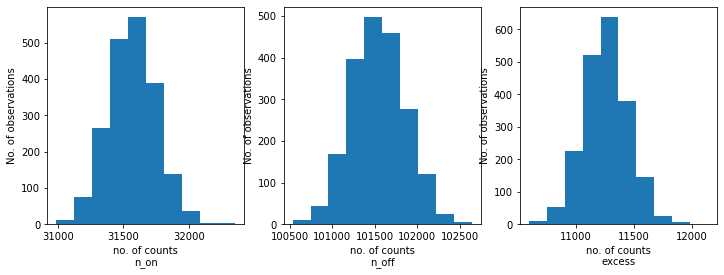

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 4min 35s, sys: 609 ms, total: 4min 35s
Wall time: 4min 35s


In [15]:
results

[{'index': 2.2277014890350046,
  'amplitude': 1.2361699597883032e-12,
  'lambda_': 0.8771913199199592},
 {'index': 2.256141939366527,
  'amplitude': 1.1592170018498003e-12,
  'lambda_': 0.9123668648988691},
 {'index': 2.2673187750347403,
  'amplitude': 1.164801174921426e-12,
  'lambda_': 0.9770119045607368},
 {'index': 2.204478662830411,
  'amplitude': 1.3707461586045393e-12,
  'lambda_': 1.1180169016820818},
 {'index': 2.162123369183518,
  'amplitude': 1.4941489960213284e-12,
  'lambda_': 1.149481269135693},
 {'index': 2.16195812798937,
  'amplitude': 1.4656723948010833e-12,
  'lambda_': 1.1630444804572702},
 {'index': 2.247214118644901,
  'amplitude': 1.2213017496185367e-12,
  'lambda_': 0.9388338034853017},
 {'index': 2.221837157834904,
  'amplitude': 1.2866730136361347e-12,
  'lambda_': 0.9936044166833219},
 {'index': 2.213182287647928,
  'amplitude': 1.2811266719895797e-12,
  'lambda_': 0.983066055358285},
 {'index': 2.2502531549190885,
  'amplitude': 1.1879297852981216e-12,
  'la

index: 2.218543418965502 += 0.03264402069767908


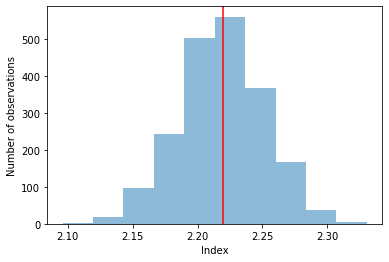

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2970086345762293e-12 += 1.0219775296951088e-13


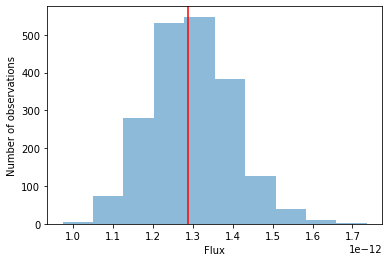

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 1.0034435839496707 += 0.08160049384677047


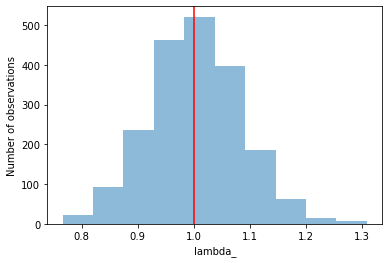

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")